<div class="alert alert-primary" style="margin-top: 20px; padding: 20px; border-radius: 10px;background-color:  #21D375 ; color: softblue;">

<h1><center>Demand Forecasting</center></h1>
    
</div>

# Importing

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import plotly.express as px

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.filterwarnings("ignore")

# Load DataSet

In [2]:
train = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv", parse_dates=["date"])
test = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv", parse_dates=["date"])

df = pd.concat([train,test], sort=False)

# Exploratory Data Analysis (EDA)¶

In [3]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [5]:
df[["store"]].nunique()
df[["item"]].nunique()

store    10
dtype: int64

item    50
dtype: int64

In [6]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

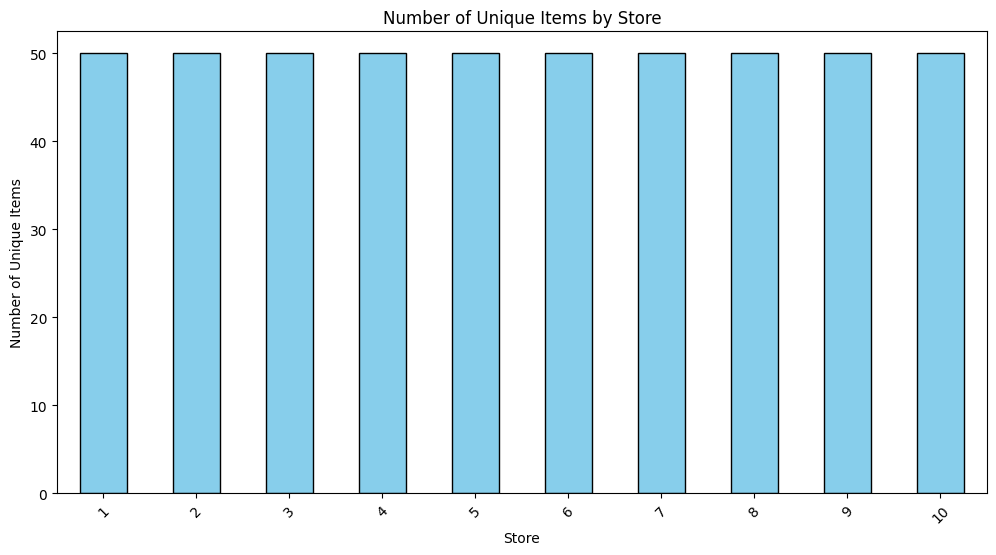

In [7]:
plt.figure(figsize=(12, 6))
df.groupby(["store"])["item"].nunique().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Store')
plt.ylabel('Number of Unique Items')
plt.title('Number of Unique Items by Store')
plt.xticks(rotation=45)  # X eksenindeki etiketleri döndürme
plt.show();

In [8]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

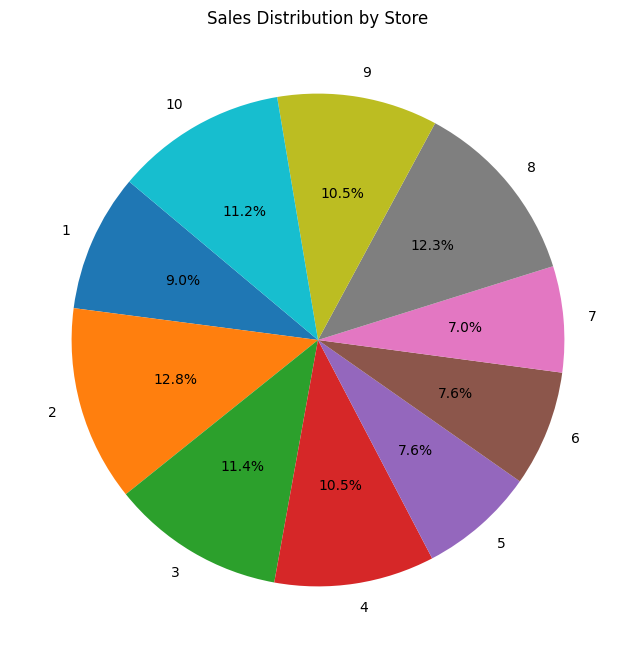

In [9]:
store_sales = df.groupby('store')['sales'].sum()

plt.figure(figsize=(8, 8))
plt.pie(store_sales, labels=store_sales.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Distribution by Store')
plt.show();

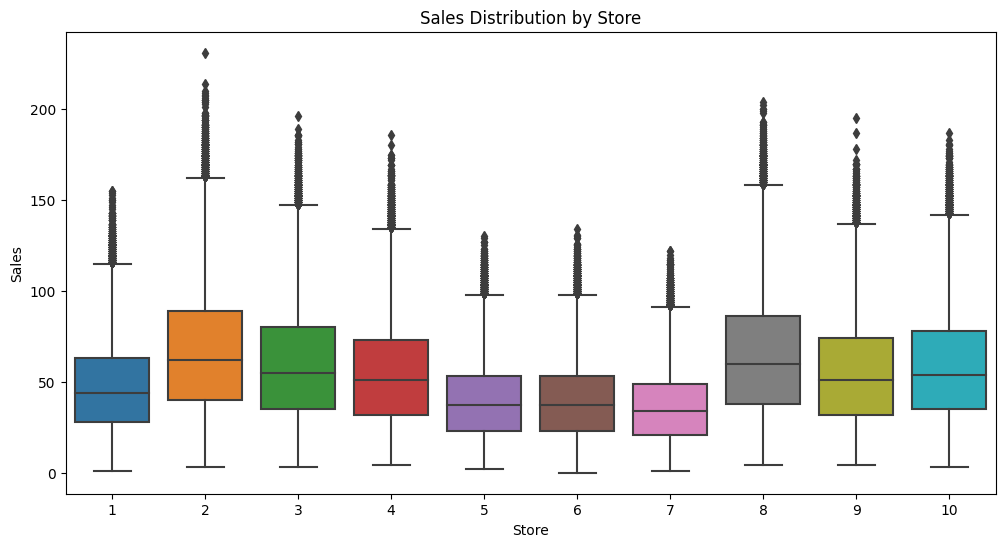

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='store', y='sales', data=df)
plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('Sales Distribution by Store')
plt.show();

In [11]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

# Feature Engineering

In [12]:
def create_date_features(df):
    df["month"] = df.date.dt.month
    df["day_of_month"] = df.date.dt.day
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week
    df["day_of_week"] = df.date.dt.dayofweek
    df["year"] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["is_month_start"] = df.date.dt.is_month_start.astype(int)
    df["is_month_end"] = df.date.dt.is_month_end.astype(int)
    return df

create_date_features(df)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [13]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [14]:
agg_df = df.groupby(['store', 'item', 'month']).agg({'sales': 'sum'}).reset_index()

fig = px.line(agg_df, x='month', y='sales', color='store', line_dash='item',
              title='Aylık Toplam Satışlar',
              labels={'sales': 'Toplam Satış', 'month': 'Ay'},
              markers=True)
fig.update_layout(xaxis_title='Ay', yaxis_title='Toplam Satış')
fig.show()


# Random Noise

In [15]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag / Shifted Features

In [16]:
df.sort_values(by=["store", "item", "date"], axis=0, inplace=True)

In [17]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "lag1": df["sales"].shift(1).values[0:10],
              "lag2": df["sales"].shift(2).values[0:10],
              "lag3": df["sales"].shift(3).values[0:10],
              "lag4": df["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13.0,NaN,NaN,NaN,NaN
1,11.0,13.0,NaN,NaN,NaN
2,14.0,11.0,13.0,NaN,NaN
3,13.0,14.0,11.0,13.0,NaN
4,10.0,13.0,14.0,11.0,13.0
5,12.0,10.0,13.0,14.0,11.0
6,10.0,12.0,10.0,13.0,14.0
7,9.0,10.0,12.0,10.0,13.0
8,12.0,9.0,10.0,12.0,10.0
9,9.0,12.0,9.0,10.0,12.0


In [18]:
df.groupby(["store", "item"])["sales"].head()

0         13.0
1         11.0
2         14.0
3         13.0
4         10.0
          ... 
911174    33.0
911175    37.0
911176    46.0
911177    51.0
911178    41.0
Name: sales, Length: 2500, dtype: float64

In [19]:
df.groupby(["store", "item"])["sales"].transform(lambda x:x.shift(1))

0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64

In [20]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 113, 119, 126, 182, 364, 546, 728])

check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_113            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

# Rolling Mean Features

In [21]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
              "roll4": df["sales"].rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll4
0,13.0,NaN,NaN,NaN
1,11.0,12.0,NaN,NaN
2,14.0,12.5,12.666667,NaN
3,13.0,13.5,12.666667,NaN
4,10.0,11.5,12.333333,12.2
5,12.0,11.0,11.666667,12.0
6,10.0,11.0,10.666667,11.8
7,9.0,9.5,10.333333,10.8
8,12.0,10.5,10.333333,10.6
9,9.0,10.5,10.000000,10.4


In [22]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll4": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll4
0,13.0,NaN,NaN,NaN
1,11.0,NaN,NaN,NaN
2,14.0,12.0,NaN,NaN
3,13.0,12.5,12.666667,NaN
4,10.0,13.5,12.666667,NaN
5,12.0,11.5,12.333333,12.2
6,10.0,11.0,11.666667,12.0
7,9.0,11.0,10.666667,11.8
8,12.0,9.5,10.333333,10.8
9,9.0,10.5,10.333333,10.6


In [23]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean" + str(window)] = (
                dataframe.groupby(["store", "item"])["sales"]
                .transform(lambda x: x.shift(1).rolling(
                    window=window,
                    min_periods=10,
                    win_type="triang"
                ).mean())
                + random_noise(dataframe)
        )
    return dataframe

In [24]:
df = roll_mean_features(df, [365, 546])
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_113,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean365,sales_roll_mean546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exponentially Weighted Mean Features

In [25]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.2).mean().values[0:10]})


,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.0,NaN,NaN,NaN,NaN,NaN
1,11.0,NaN,13.000000,13.000000,13.000000,13.000000
2,14.0,12.0,11.019802,11.095238,11.461538,11.888889
3,13.0,12.5,13.970201,13.855107,13.287770,12.754098
4,10.0,13.5,13.009702,13.042750,13.084686,12.837398
5,12.0,11.5,10.030097,10.152137,10.920146,11.993337
6,10.0,11.0,11.980301,11.907607,11.676595,11.995143
7,9.0,11.0,10.019803,10.095380,10.502722,11.490225
8,12.0,9.5,9.010198,9.054769,9.450748,10.891777
9,9.0,10.5,11.970102,11.852738,11.235259,11.147782


In [26]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha" + str(alpha).replace(".", "") + "_lag" + str(lag)] = (
                dataframe.groupby(["store", "item"])["sales"]
                .transform(lambda x:x.shift(lag).ewm(alpha).mean())
            )
    return dataframe

In [27]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags= [91, 98, 105, 112, 180, 270, 365, 546, 728]

ewm_features(df, alphas, lags)

check_df(df)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_113,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean365,sales_roll_mean546,sales_ewm_alpha095_lag91,sales_ewm_alpha095_lag98,sales_ewm_alpha095_lag105,sales_ewm_alpha095_lag112,sales_ewm_alpha095_lag180,sales_ewm_alpha095_lag270,sales_ewm_alpha095_lag365,sales_ewm_alpha095_lag546,sales_ewm_alpha095_lag728,sales_ewm_alpha09_lag91,sales_ewm_alpha09_lag98,sales_ewm_alpha09_lag105,sales_ewm_alpha09_lag112,sales_ewm_alpha09_lag180,sales_ewm_alpha09_lag270,sales_ewm_alpha09_lag365,sales_ewm_alpha09_lag546,sales_ewm_alpha09_lag728,sales_ewm_alpha08_lag91,sales_ewm_alpha08_lag98,sales_ewm_alpha08_lag105,sales_ewm_alpha08_lag112,sales_ewm_alpha08_lag180,sales_ewm_alpha08_lag270,sales_ewm_alpha08_lag365,sales_ewm_alpha08_lag546,sales_ewm_alpha08_lag728,sales_ewm_alpha07_lag91,sales_ewm_alpha07_lag98,sales_ewm_alpha07_lag105,sales_ewm_alpha07_lag112,sales_ewm_alpha07_lag180,sales_ewm_alpha07_lag270,sales_ewm_alpha07_lag365,sales_ewm_alpha07_lag546,sales_ewm_alpha07_lag728,sales_ewm_alpha05_lag91,sales_ewm_alpha05_lag98,sales_ewm_alpha05_lag105,sales_ewm_alpha05_lag112,sales_ewm_alpha05_lag180,sales_ewm_alpha05_lag270,sales_ewm_alpha05_lag365,sales_ewm_alpha05_lag546,sales_ewm_alpha05_lag728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,38.989859,54.301622,65.929909,51.887394,69.128943,79.982547,80.559538,57.919877,96.411164,74.412044,88.389484,85.800955,50.952065,58.454257,64.034838,64.351258,80.820935,109.282875,71.670989,85.530733,68.912345,50.577359,58.251674,64.038854,64.375436,80.818558,109.536387,71.597076,85.582383,68.892732,49.773838,57.820920,64.058807,64.450181,80.832192,110.062208,71.413950,85.724810,68.863290,48.893468,57.354445,64.100897,64.564850,80.874222,110.607218,71.172962,85.940459,68.856247,46.887203,56.312894,64.298558,64.945273,81.060052,111.697557,70.451048,86.754293,68.985741
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.961001,49.371806,64.701988,66.686504,76.370791,78.667672,80.516757,76.611543,83.086318,68.882088,84.744586,82.908736,57.130493,54.631561,65.555434,62.119844,85.528148,114.266016,65.685867,82.694460,68.444476,57.115591,

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                        datetime64[ns]
store                                int64
item                                 int64
sales                              float64
id                                 float64
                                 ...      
sales_ewm_alpha05_lag180           float64
sales_ewm_alpha05_lag270           float64
sales_ewm_alpha05_lag365           float64
sales_ewm_alpha05_lag546           float64
sales_ewm_alpha05_lag728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_113  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean365  sales_roll_mean546  sales_e

# One-hot encoding

In [28]:
df = pd.get_dummies(df, columns=["store", "item", "day_of_week", "month"])

# Converting sales to log(1 + sales)

In [29]:
df["sales"] = np.log1p(df["sales"].values)

# Custom cost function

In [30]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [31]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False


# Time_based validation sets

In [32]:
train = df.loc[(df["date"] < "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]
cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

In [33]:
Y_train = train["sales"]
X_train = train[cols]

Y_val = val["sales"]
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730500,), (730500, 142), (45000,), (45000, 142))

# LightGBM Parameters

In [34]:
lgb_params = {"num_leaves": 10,
              "learning_rate": 0.02,
              "feature_fraction": 0.8,
              "max_depth": 5,
              "verbose": 0,
              "num_boost_round": 1000,
              "early_stopping_rounds": 200,
              "nthread": -1}

In [35]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [36]:
model = lgb.train(lgb_params,
                  lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params["num_boost_round"],
                  callbacks=[lgb.early_stopping(stopping_rounds=lgb_params["early_stopping_rounds"]), lgb.log_evaluation(100) ],
                  feval=lgbm_smape)

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0513475	training's SMAPE: 17.5976	valid_1's l2: 0.0535488	valid_1's SMAPE: 17.5399
[200]	training's l2: 0.0352256	training's SMAPE: 14.5687	valid_1's l2: 0.0371604	valid_1's SMAPE: 14.9257
[300]	training's l2: 0.0324433	training's SMAPE: 14.0115	valid_1's l2: 0.0341629	valid_1's SMAPE: 14.4461
[400]	training's l2: 0.0313744	training's SMAPE: 13.7962	valid_1's l2: 0.0332527	valid_1's SMAPE: 14.2792
[500]	training's l2: 0.0307052	training's SMAPE: 13.6629	valid_1's l2: 0.0326524	valid_1's SMAPE: 14.1468
[600]	training's l2: 0.0302482	training's SMAPE: 13.5689	valid_1's l2: 0.0321736	valid_1's SMAPE: 14.0332
[700]	training's l2: 0.0299045	training's SMAPE: 13.4979	valid_1's l2: 0.0318705	valid_1's SMAPE: 13.9627
[800]	training's l2: 0.0296234	training's SMAPE: 13.4418	valid_1's l2: 0.0316435	valid_1's SMAPE: 13.9097
[900]	training's l2: 0.0293703	training's SMAPE: 13.3921	valid_1's l2: 0.0314547	valid_1's

In [37]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.829603502263794

# Feature importance

In [38]:
def plot_lgb_importance(model, plot=False, num=10):
    gain = model.feature_importance("gain")
    feat_imp = pd.DataFrame({"feature": model.feature_name(),
                             "split": model.feature_importance("split"),
                             "gain": 100 * gain / gain.sum()}).sort_values("gain", ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

                       feature  split       gain
17          sales_roll_mean546    935  54.421389
13               sales_lag_364   1249  13.147940
16          sales_roll_mean365    634   9.802569
24   sales_ewm_alpha095_lag365    308   4.508804
6                 sales_lag_91    177   3.417656
1                  day_of_year    764   2.239838
45     sales_ewm_alpha07_lag91     16   1.838161
54     sales_ewm_alpha05_lag91     31   1.505060
3                      is_wknd    232   1.206628
123              day_of_week_0    238   1.186445
141                   month_12    306   1.155915
7                 sales_lag_98     35   0.840207
2                 week_of_year    292   0.837891
62    sales_ewm_alpha05_lag728     46   0.545725
33    sales_ewm_alpha09_lag365     74   0.466993
26   sales_ewm_alpha095_lag728    290   0.300906
23   sales_ewm_alpha095_lag270    130   0.248741
15               sales_lag_728     19   0.205461
136                    month_7    135   0.116391
12               sal

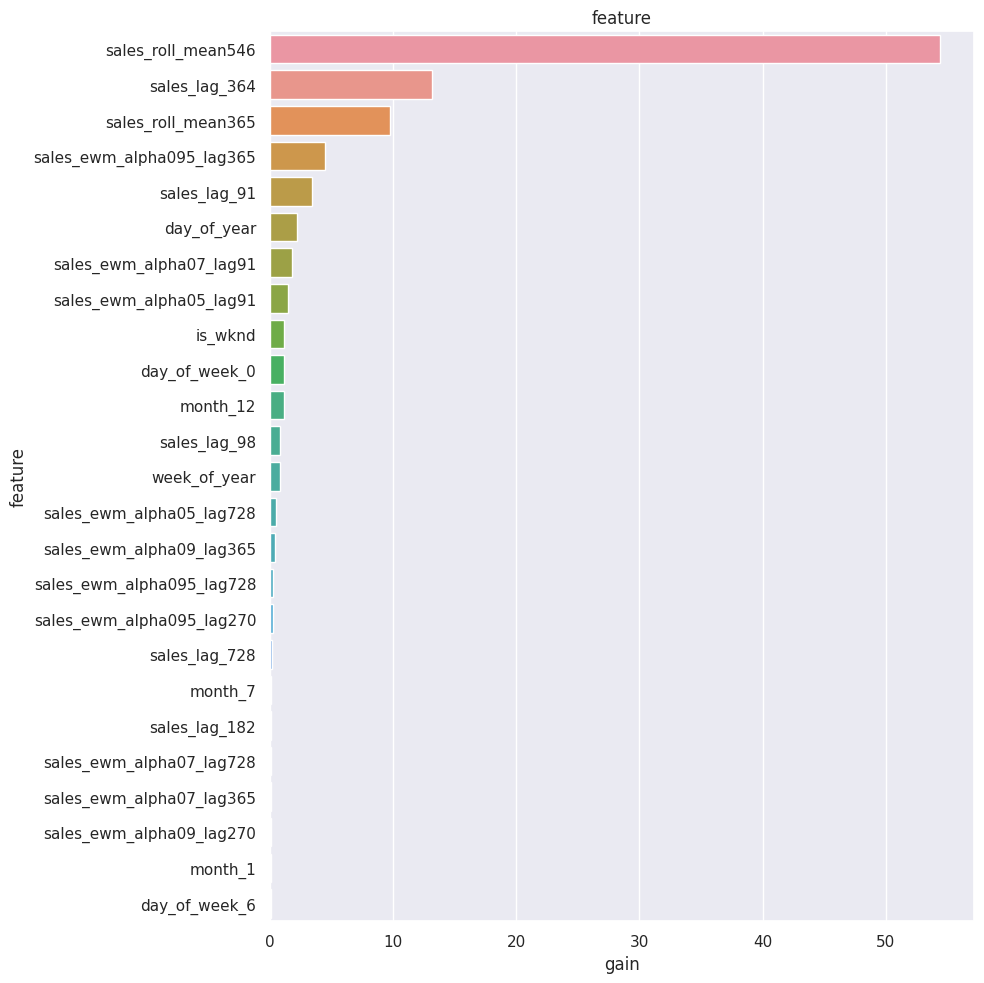

,feature,split,gain
17,sales_roll_mean546,935,54.421389
13,sales_lag_364,1249,13.147940
16,sales_roll_mean365,634,9.802569
24,sales_ewm_alpha095_lag365,308,4.508804
6,sales_lag_91,177,3.417656
...,...,...,...
72,store_10,0,0.000000
107,item_35,0,0.000000
111,item_39,0,0.000000
83,item_11,0,0.000000


111

In [39]:
feat_imp = plot_lgb_importance(model, num=30)
plot_lgb_importance(model, plot=True, num=30)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

# Final model

In [40]:
train = df.loc[~df.sales.isna()]
Y_train = train["sales"]
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [41]:
lgb_params = {"num_leaves": 10,
              "learning_rate": 0.02,
              "feature_fraction": 0.8,
              "max_depth": 5,
              "verbose": 0,
              "num_boost_round": model.best_iteration,
              "nthread": -1}

In [42]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round = model.best_iteration)

test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

# Submission File

In [43]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_113,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean365,sales_roll_mean546,sales_ewm_alpha095_lag91,sales_ewm_alpha095_lag98,sales_ewm_alpha095_lag105,sales_ewm_alpha095_lag112,sales_ewm_alpha095_lag180,sales_ewm_alpha095_lag270,sales_ewm_alpha095_lag365,sales_ewm_alpha095_lag546,sales_ewm_alpha095_lag728,sales_ewm_alpha09_lag91,sales_ewm_alpha09_lag98,sales_ewm_alpha09_lag105,sales_ewm_alpha09_lag112,sales_ewm_alpha09_lag180,sales_ewm_alpha09_lag270,sales_ewm_alpha09_lag365,sales_ewm_alpha09_lag546,sales_ewm_alpha09_lag728,sales_ewm_alpha08_lag91,sales_ewm_alpha08_lag98,sales_ewm_alpha08_lag105,sales_ewm_alpha08_lag112,sales_ewm_alpha08_lag180,sales_ewm_alpha08_lag270,sales_ewm_alpha08_lag365,sales_ewm_alpha08_lag546,sales_ewm_alpha08_lag728,sales_ewm_alpha07_lag91,sales_ewm_alpha07_lag98,sales_ewm_alpha07_lag105,sales_ewm_alpha07_lag112,sales_ewm_alpha07_lag180,sales_ewm_alpha07_lag270,sales_ewm_alpha07_lag365,sales_ewm_alpha07_lag546,sales_ewm_alpha07_lag728,sales_ewm_alpha05_lag91,sales_ewm_alpha05_lag98,sales_ewm_alpha05_lag105,sales_ewm_alpha05_lag112,sales_ewm_alpha05_lag180,sales_ewm_alpha05_lag270,sales_ewm_alpha05_lag365,sales_ewm_alpha05_lag546,sales_ewm_alpha05_lag728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,12.963963,18.001131,22.059738,30.977736,10.428992,17.602666,19.294108,14.069578,17.608840,13.006093,24.237508,22.081462,18.013553,20.504979,24.939806,22.243896,23.722826,22.932645,18.238155,25.810485,12.855210,17.824430,20.326603,24.902208,22.096133,23.642079,22.999785,18.240779,25.621644,12.804552,17.413717,19.930824,24.807283,21.767449,23.485309,23.141682,18.244264,25.201288,12.697937,16.954911,19.475750,24.680809,21.387812,23.338163,23.295318,18.246228,24.715586,12.585325,15.868472,18.348561,24.301982,20.434512,23.093276,23.647479,18.256262,23.497849,12.352076,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,18.982932,15.562314,22.941317,18.212828,23.770337,19.245036,22.035812,10.994904,30.008495,13.092843,23.743448,20.957229,18.006603,19.220374,22.919392,21.093180,27.454710,23.992827,16.577562,28.471775,12.416641,17.916835,19.102075,22.848414,20.992905,27.514669,24.052530,16.535106,28.452358,12.381104,17.739430,18.858144,22.692126,20.785533,27.660137,24.174081,16.441895,28.422795,12.310194,17.569669,18.607662,22.515627,20.571452,27.845126,24.298072,16.336682,28.412300,12.241016,17.289491,18.116187,22.100661,20.144837,28.364425,24.549160,16.085421,28.499283,12.117359,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [44]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df["sales"] = np.expm1(test_preds)

submission_df["id"] = submission_df.id.astype(int)

In [45]:
submission_df.to_csv("submission.csv", index=False)